In [46]:
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import numpy as np
import sklearn
import mne_icalabel

Open BDF file/ Remove unused BioSemi channels

In [47]:
raw = mne.io.read_raw_bdf("/Users/hrakol/Desktop/Thesis EEG/user_18_session_1.bdf", preload = True) 

raw_data = raw.copy()
raw_data.pick(raw_data.ch_names[:32])

Extracting EDF parameters from /Users/hrakol/Desktop/Thesis EEG/user_18_session_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401407  =      0.000 ...   196.000 secs...


<RawEDF | user_18_session_1.bdf, 32 x 401408 (196.0 s), ~98.0 MB, data loaded>

Get Events through trigger(Status) channel

In [48]:
events = mne.find_events(raw, stim_channel = 'Status', shortest_event = 1)

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15 events found on stim channel Status
Event IDs: [2]


Deleta data recorded before the experiment starts

In [49]:
first_stim = events[events[:, 2] == 2][0, 0] #find the first code 2 event in frames
last_stim = events[events[:, 2] == 2][-1, 0]
first_stim_time = raw_data.times[first_stim]
last_stim_time = raw_data.times[last_stim]
start_time = max(0, first_stim_time - 3.0)
end_time = min(raw_data.times[-1], last_stim_time + 1.0  # stim duration
                                                  + 2.0  # extra time until resting state screen closes
                                                  + 1.0) # extra time to be sure    

raw_data.crop(tmin = start_time, tmax = end_time)

<RawEDF | user_18_session_1.bdf, 32 x 350622 (171.2 s), ~85.6 MB, data loaded>

Drift removal

In [50]:
raw_data.filter(l_freq = 1.0, h_freq = None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished


<RawEDF | user_18_session_1.bdf, 32 x 350622 (171.2 s), ~85.6 MB, data loaded>

Spectrum Analysis(Remove power line noise)

In [51]:
fig = raw_data.compute_psd(fmax = 250).plot(
        average = True, amplitude = False, picks = "data", exclude = "bads"
)
fig.savefig("psd_plot.png", dpi = 300)

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [52]:
freqs = (50, 100, 150, 200, 250)
raw_data.notch_filter(freqs = freqs, method = "spectrum_fit")
fig = raw_data.compute_psd(fmax = 250).plot(
        average = True, amplitude = False, picks = "data", exclude = "bads"
)
fig.savefig("psd_after_notch_plot.png", dpi = 300)

Filtering raw data in 1 contiguous segment
Removed notch frequencies (Hz):
     50.00 : 1056 windows
    100.00 : 1056 windows
    150.00 : 1056 windows
    200.00 : 1056 windows
    249.00 : 1056 windows
    250.00 : 1056 windows
    251.00 : 1056 windows
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Set up CAR and filter to get ready for icalabel

In [53]:
raw_clean = raw_data.copy()
raw_clean.set_eeg_reference("average", projection = False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | user_18_session_1.bdf, 32 x 350622 (171.2 s), ~85.6 MB, data loaded>

Artifact removal 

In [70]:
ica = ICA(n_components = 0.999, max_iter = "auto", method = 'infomax', fit_params=dict(extended = True), random_state = 18) # 0.999 to show variance
ica.fit(raw_clean)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 28 components
Computing Extended Infomax ICA
Fitting ICA took 17.3s.


/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/utils/linalg.py:243: RuntimeWarning: divide by zero encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/utils/linalg.py:243: RuntimeWarning: overflow encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/utils/linalg.py:243: RuntimeWarning: invalid value encountered in matmul
  return (u @ vh[:rank]).conj().T


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (350622 samples)
ICA components,28
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


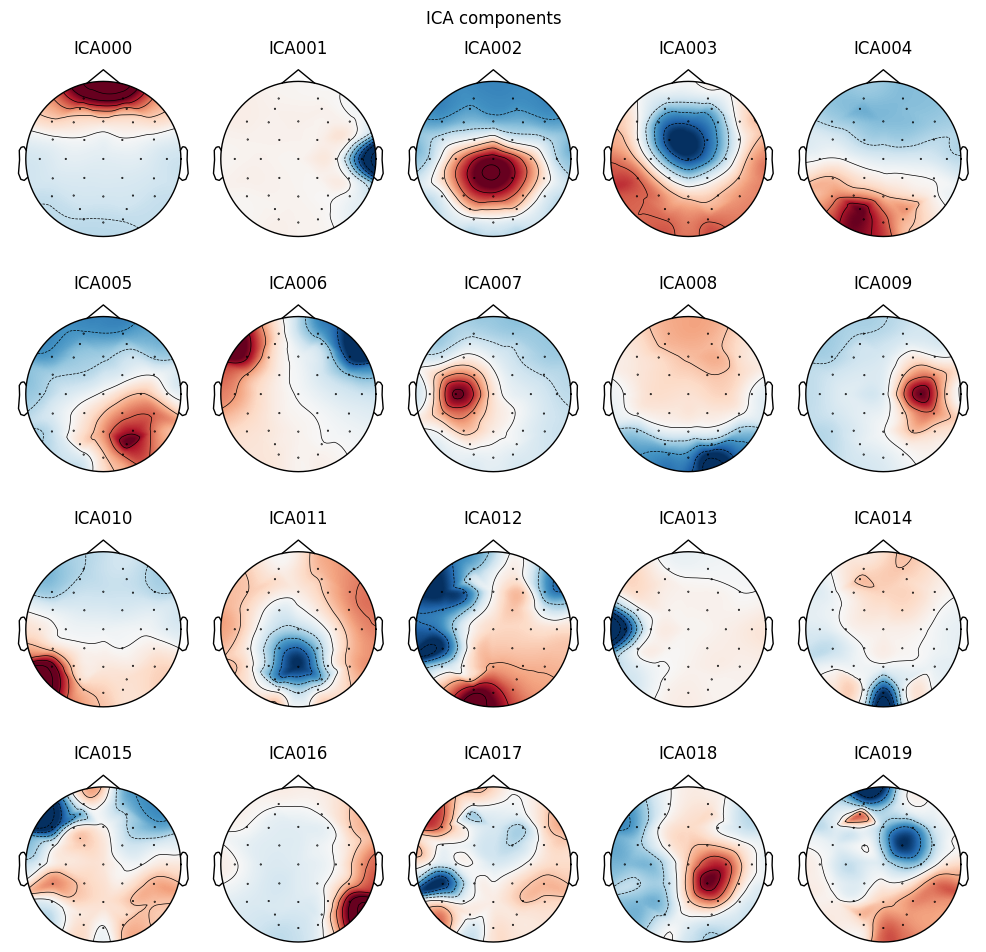

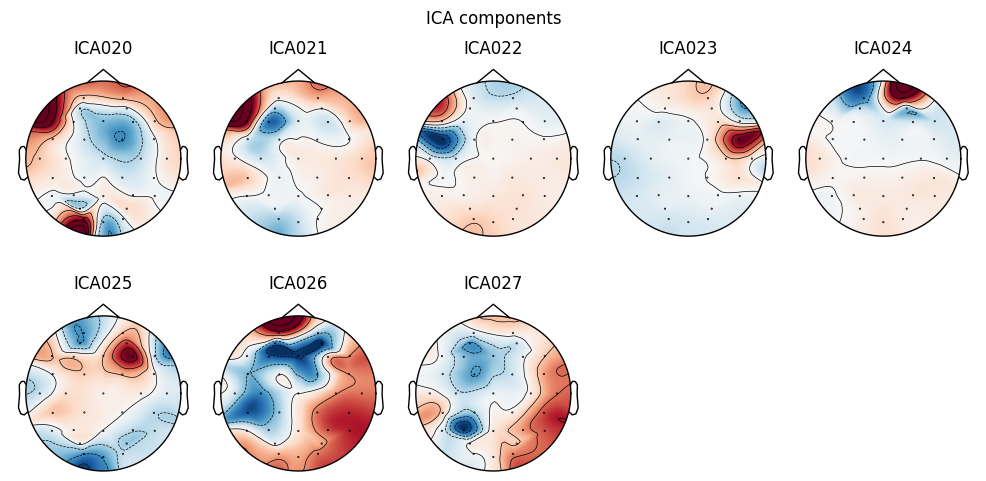

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 8 Axes>]

In [71]:
montage = mne.channels.make_standard_montage(kind = "biosemi32")

rename_dict = dict(zip(raw_clean.ch_names, montage.ch_names)) #rename raw_data channel names to match the 
raw_clean.rename_channels(rename_dict)                        #biosemi32 channel names

raw_clean.set_montage(montage)
ica.plot_components()

Creating RawArray with float64 data, n_channels=28, n_times=350622
    Range : 29877 ... 380498 =     14.588 ...   185.790 secs
Ready.


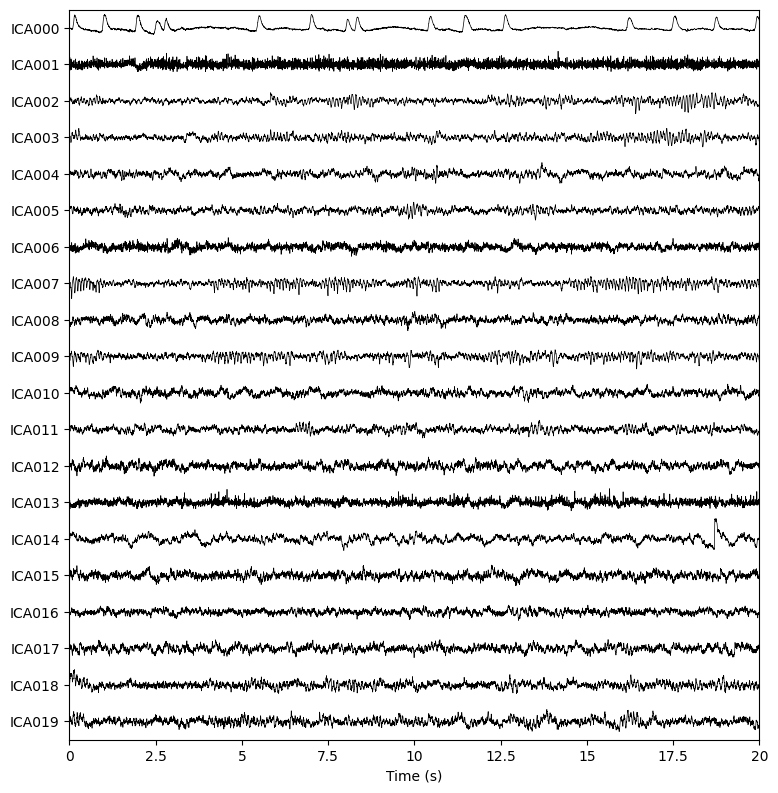

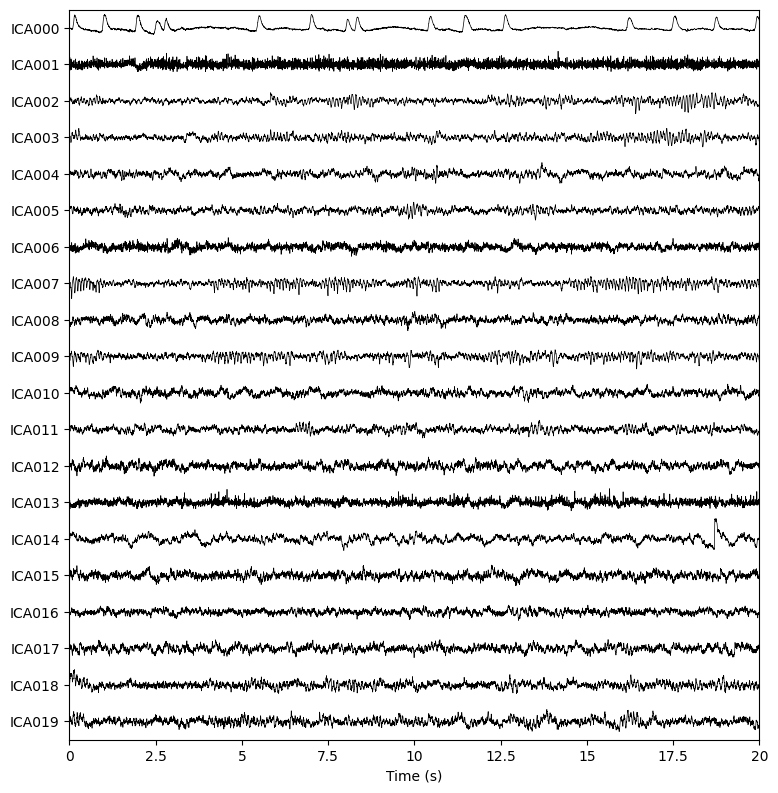

In [72]:
ica.plot_sources(raw_clean, show_scrollbars = False)

EOG artifacts

In [79]:
eog_inds, eog_scores = ica.find_bads_eog(raw_clean, ch_name = ["Fp1", "Fp2"])

Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [ ]:
#ica.exclude = ica.labels_["eog"]
#[clean_raw] = ica.apply(raw.copy())

ECG artifacts

In [67]:
raw_clean.filter(l_freq = 1., h_freq = 100.)
ica_labels = mne_icalabel.label_components(raw_clean, ica, method = "iclabel")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: divide by zero encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: overflow encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: invalid value encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/hrakol/Library

In [68]:
print(ica_labels["labels"])
print(ica_labels["y_pred_proba"])

['eye blink', 'muscle artifact', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'other', 'brain', 'other', 'brain', 'brain', 'brain', 'other', 'other', 'brain', 'other', 'brain', 'brain', 'eye blink', 'brain', 'other', 'other', 'other', 'other']
[0.99852055 0.99995124 0.9999992  0.9999918  0.9992066  0.98086405
 0.99797535 0.99945563 0.9883243  0.99884444 0.9314601  0.5807384
 0.998037   0.7286643  0.73862654 0.77419263 0.60953486 0.92749417
 0.62037456 0.7998125  0.7958631  0.99862397 0.5782198  0.99142194
 0.8553252  0.72915787 0.67843854 0.4652136  0.5698241 ]


Compare EOG and ICALABEL results for eye-blink artifacts

In [84]:
iclabel_eye_components = [i for i, label in enumerate(ica_labels['labels']) if label == 'eye blink']
overlap = set(iclabel_eye_components) & set(eog_inds)
only_iclabel = set(iclabel_eye_components) - set(eog_inds)
only_find_bads = set(eog_inds) - set(iclabel_eye_components)

print("overlap:", overlap)
print("Only in ICLabel:", only_iclabel)
print("Only in find_bads_eog:", only_find_bads)

overlap: {np.int64(0)}
Only in ICLabel: {10, 5, 23}
Only in find_bads_eog: set()


In [89]:
print(iclabel_eye_components)
print(eog_scores)

[0, 5, 10, 23]
[array([ 0.98443603, -0.02152503, -0.08770767, -0.035844  , -0.05191299,
       -0.08912773,  0.00674981, -0.05672983,  0.05338372, -0.05754679,
       -0.05345128,  0.02562487, -0.03392483, -0.01572255,  0.03944194,
        0.00434345,  0.00436288, -0.01087646,  0.0128957 , -0.02190454,
        0.01317473,  0.00750957, -0.01590292,  0.02922973, -0.05385167,
       -0.02886476,  0.01817141,  0.00635001]), array([ 9.82005961e-01, -2.67348027e-02, -8.43525286e-02, -2.68452123e-02,
       -4.85773605e-02, -8.20269697e-02, -8.73128035e-02, -6.83136092e-02,
        5.54173204e-02, -4.61811329e-02, -4.33543773e-02,  5.31257397e-02,
       -3.66862017e-04, -1.27441740e-02,  4.25829572e-02, -2.89806558e-02,
        9.67726798e-03, -1.01298732e-02,  1.99754959e-02,  9.60875366e-03,
        1.93799625e-02,  2.20813156e-02, -2.48727626e-02,  3.74702773e-02,
        4.08882682e-02,  1.71406146e-02, -9.35847759e-03,  1.81144504e-02])]


Resample

In [ ]:
#raw_data.filter(h_freq = 70.0)
#raw_data.resample(256)